## Define the Convolutional Neural Network

model in the provided file `models.py` file

In [3]:
# import the usual resources
import matplotlib.pyplot as plt
import numpy as np

# watch for any changes in model.py, if it changes, re-load it automatically
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [57]:
# check if CUDA is available
use_cuda = torch.cuda.is_available()
use_cuda

True

In [74]:
## Define the Net in models.py

import torch
import torch.nn as nn
import torch.nn.functional as F


from models import Net

net = Net()
if use_cuda:
    net = net.cuda()
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (conv6): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv7): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1))
  (conv8): Conv2d(256, 256, kernel_size=(5, 5), stride=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (FC1): Linear(in_features=9216, out_features=1024, bias=True)
  (FC2): Linear(in_features=1024, out_features=136, bias=True)
  (Dropout): Dropout(p=0.2)
)


## Transform the dataset 



In [75]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# the dataset we created in Notebook 1 is copied in the helper file `data_load.py`
from data_load import FacialKeypointsDataset
# the transforms we defined in Notebook 1 are in the helper file `data_load.py`
from data_load import Rescale, RandomCrop, Normalize, ToTensor


data_transform = transforms.Compose([Rescale(250),
                                   RandomCrop(224),
                                   Normalize(),
                                   ToTensor()])

# testing that you've defined a transform
assert(data_transform is not None), 'Define a data_transform'

In [76]:
# create the transformed dataset
transformed_dataset = FacialKeypointsDataset(csv_file='data/training_frames_keypoints.csv',
                                             root_dir='data/training/',
                                             transform=data_transform)


print('Number of images: ', len(transformed_dataset))

# iterate through the transformed dataset and print some stats about the first few samples
for i in range(4):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

Number of images:  3462
0 torch.Size([1, 224, 224]) torch.Size([68, 2])
1 torch.Size([1, 224, 224]) torch.Size([68, 2])
2 torch.Size([1, 224, 224]) torch.Size([68, 2])
3 torch.Size([1, 224, 224]) torch.Size([68, 2])


## Batching and loading data



In [102]:
# load training data in batches
##batch_size = 10 updated
batch_size = 20
train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)


## Before training

#### Load in the test dataset



In [103]:
# load in the test data, using the dataset class
# AND apply the data_transform you defined above

# create the test dataset
test_dataset = FacialKeypointsDataset(csv_file='data/test_frames_keypoints.csv',
                                             root_dir='data/test/',
                                             transform=data_transform)



In [104]:
# load test data in batches
###batch_size = 10 Updated Kaustav
batch_size = 20

test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)

## Apply the model on a test sample

To test the model on a test sample of data, you have to follow these steps:
1. Extract the image and ground truth keypoints from a sample
2. Make sure the image is a FloatTensor, which the model expects.
3. Forward pass the image through the net to get the predicted, output keypoints.

This function test how the network performs on the first batch of test data. It returns the images, the transformed images, the predicted keypoints (produced by the model), and the ground truth keypoints.

In [105]:
# test the model on a batch of test images

def net_sample_output():
    
    # iterate through the test dataset
    for i, sample in enumerate(test_loader):
        
        # get sample data: images and ground truth keypoints
        images = sample['image']
        key_pts = sample['keypoints']
        
        if use_cuda:
            images,key_pts = images.cuda(),key_pts.cuda()
            # convert images to FloatTensors
            images = images.type(torch.cuda.FloatTensor)
        else:
            # convert images to FloatTensors
            images = images.type(torch.FloatTensor)

        # forward pass to get net output
        output_pts = net(images)
        
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        
        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts
            

#### Debugging tips

If you get a size or dimension error here, make sure that your network outputs the expected number of keypoints! Or if you get a Tensor type error, look into changing the above code that casts the data into float types: `images = images.type(torch.FloatTensor)`.

In [106]:
# call the above function
# returns: test images, test predicted keypoints, test ground truth keypoints
test_images, test_outputs, gt_pts = net_sample_output()

# print out the dimensions of the data to see if they make sense
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([20, 1, 224, 224])
torch.Size([20, 68, 2])
torch.Size([20, 68, 2])


## Visualize the predicted keypoints

Once we've had the model produce some predicted output keypoints, we can visualize these points in a way that's similar to how we've displayed this data before, only this time, we have to "un-transform" the image/keypoint data to display it.

Note that I've defined a *new* function, `show_all_keypoints` that displays a grayscale image, its predicted keypoints and its ground truth keypoints (if provided).

In [107]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')


#### Un-transformation

Next, you'll see a helper function. `visualize_output` that takes in a batch of images, predicted keypoints, and ground truth keypoints and displays a set of those images and their true/predicted keypoints.

This function's main role is to take batches of image and keypoint data (the input and output of your CNN), and transform them into numpy images and un-normalized keypoints (x, y) for normal display. The un-transformation process turns keypoints and images into numpy arrays from Tensors *and* it undoes the keypoint normalization done in the Normalize() transform; it's assumed that you applied these transformations when you loaded your test data.

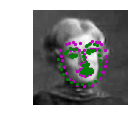

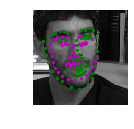

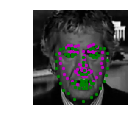

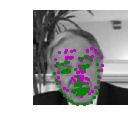

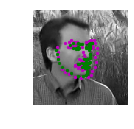

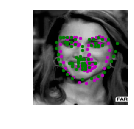

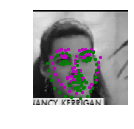

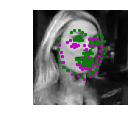

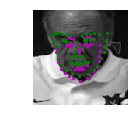

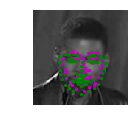

In [108]:
# visualize the output
# by default this shows a batch of 10 images
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):

    for i in range(batch_size):
        plt.figure(figsize=(20,10))
        ax = plt.subplot(1, batch_size, i+1)

        # un-transform the image data
        image = test_images[i].data   # get the image from it's wrapper
        if use_cuda:
            image = image.cpu()
        image = image.numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        if use_cuda:
            predicted_key_pts= predicted_key_pts.cpu()
        predicted_key_pts = predicted_key_pts.numpy()
        # undo normalization of keypoints  
        predicted_key_pts = predicted_key_pts*50.0+100
        
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*50.0+100
        
        # call show_all_keypoints
        if use_cuda:
            ground_truth_pts = ground_truth_pts.cpu()
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
            
        plt.axis('off')

    plt.show()
    
# call it
visualize_output(test_images, test_outputs, gt_pts)

##### loss and optimization


In [109]:

import torch.optim as optim

criterion = nn.MSELoss()

optimizer = optim.Adam(net.parameters(),lr =.0002)


## Training and Initial Observation



In [96]:
def train_net(n_epochs):

    # prepare the net for training
    net.train()

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0

        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['keypoints']

            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)
            
            if use_cuda:
                images,key_pts = images.cuda(),key_pts.cuda()

            # convert variables to floats for regression loss
            if use_cuda:
                key_pts = key_pts.type(torch.cuda.FloatTensor)
                images = images.type(torch.cuda.FloatTensor)
            else:
                key_pts = key_pts.type(torch.FloatTensor)
                images = images.type(torch.FloatTensor)

            # forward pass to get outputs
            output_pts = net(images)

            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()
            
            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()

            # print loss statistics
            # to convert loss into a scalar and add it to the running_loss, use .item()
            running_loss += loss.item()
            if batch_i % 10 == 9:    # print every 10 batches
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, running_loss/1000))
                running_loss = 0.0

    print('Finished Training')


In [110]:
# train your network
n_epochs = 10 # start small, and increase when you've decided on your model structure and hyperparams

train_net(n_epochs)

Epoch: 1, Batch: 10, Avg. Loss: 0.0008109260536730289
Epoch: 1, Batch: 20, Avg. Loss: 0.0006918103583157063
Epoch: 1, Batch: 30, Avg. Loss: 0.0007950733043253421
Epoch: 1, Batch: 40, Avg. Loss: 0.0007494733817875385
Epoch: 1, Batch: 50, Avg. Loss: 0.0008282168582081794
Epoch: 1, Batch: 60, Avg. Loss: 0.0008883269727230072
Epoch: 1, Batch: 70, Avg. Loss: 0.0007837465591728687
Epoch: 1, Batch: 80, Avg. Loss: 0.0007038702219724655
Epoch: 1, Batch: 90, Avg. Loss: 0.0009783229008316994
Epoch: 1, Batch: 100, Avg. Loss: 0.0008085004426538944
Epoch: 1, Batch: 110, Avg. Loss: 0.0008694492802023887
Epoch: 1, Batch: 120, Avg. Loss: 0.0006380886882543564
Epoch: 1, Batch: 130, Avg. Loss: 0.0007619092762470246
Epoch: 1, Batch: 140, Avg. Loss: 0.0008731465078890324
Epoch: 1, Batch: 150, Avg. Loss: 0.001013710230588913
Epoch: 1, Batch: 160, Avg. Loss: 0.0007544943615794182
Epoch: 1, Batch: 170, Avg. Loss: 0.0017157867439091205
Epoch: 2, Batch: 10, Avg. Loss: 0.0007291212044656277
Epoch: 2, Batch: 20, 

## Test data

See how your model performs on previously unseen, test data. We've already loaded and transformed this data, similar to the training data. Next, run your trained model on these images to see what kind of keypoints are produced. You should be able to see if your model is fitting each new face it sees, if the points are distributed randomly, or if the points have actually overfitted the training data and do not generalize.

In [111]:
# get a sample of test data again
test_images, test_outputs, gt_pts = net_sample_output()

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([20, 1, 224, 224])
torch.Size([20, 68, 2])
torch.Size([20, 68, 2])


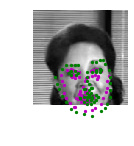

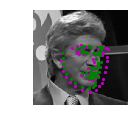

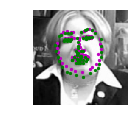

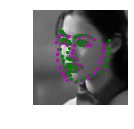

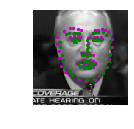

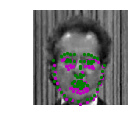

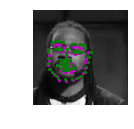

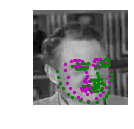

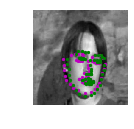

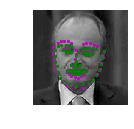

In [162]:


visualize_output(test_images, test_outputs, gt_pts)

Once you've found a good model (or two), save your model so you can load it and use it later!

In [114]:
## change the name to something uniqe for each new model
model_dir = 'saved_models/'
model_name = 'keypoints_model_2.pt'

# after training, save your model parameters in the dir 'saved_models'
torch.save(net.state_dict(), model_dir+model_name)

## Feature Visualization


In the cell below, you can see how to extract a single filter (by index) from your first convolutional layer. The filter should appear as a grayscale grid.

[[ 0.10441953 -0.12062579  0.12501584 -0.13759768  0.02008116]
 [-0.0425841   0.02721626 -0.03949052 -0.10368799  0.19246125]
 [ 0.09772339 -0.08680494  0.05441885 -0.01153405  0.0720234 ]
 [-0.00494209  0.11902128 -0.16371462  0.10435973 -0.12628119]
 [ 0.03864931 -0.12197854 -0.07390951  0.15018657 -0.04450974]]
(5, 5)


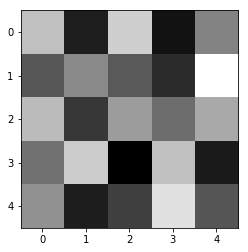

In [163]:
# Get the weights in the first conv layer, "conv1"
# if necessary, change this to reflect the name of your first conv layer
weights1 = net.conv1.weight.data.cpu()

w = weights1.numpy()

filter_index = 0

print(w[filter_index][0])
print(w[filter_index][0].shape)

# display the filter weights
plt.imshow(w[filter_index][0], cmap='gray')


## Feature maps

Each CNN has at least one convolutional layer that is composed of stacked filters (also known as convolutional kernels). As a CNN trains, it learns what weights to include in it's convolutional kernels and when these kernels are applied to some input image, they produce a set of **feature maps**. So, feature maps are just sets of filtered images; they are the images produced by applying a convolutional kernel to an input image. These maps show us the features that the different layers of the neural network learn to extract. For example, you might imagine a convolutional kernel that detects the vertical edges of a face or another one that detects the corners of eyes. You can see what kind of features each of these kernels detects by applying them to an image. One such example is shown below; from the way it brings out the lines in an the image, you might characterize this as an edge detection filter.

<img src='images/feature_map_ex.png' width=50% height=50%/>


Next, choose a test image and filter it with one of the convolutional kernels in your trained CNN; look at the filtered output to get an idea what that particular kernel detects.

### TODO: Filter an image to see the effect of a convolutional kernel
---

Text(0.5, 1.0, 'Filter')

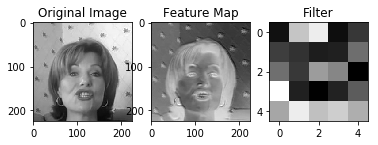

In [176]:

## TODO: Using cv's filter2D function,
## apply a specific set of filter weights (like the one displayed above) to the test image
import cv2

weights1 = net.conv1.weight.data.cpu()

w = weights1.numpy()

import cv2
## load in and display any image from the transformed test dataset
img = test_dataset[10]
img = img["image"].numpy().reshape(224,224)
fig , ax = plt.subplots(nrows=1, ncols=3)
ax[0].imshow(img,cmap='gray')
ax[0].set_title("Original Image")
## TODO: Using cv's filter2D function,
## apply a specific set of filter weights (like the one displayed above) to the test image
filter_output = cv2.filter2D(img,-1,w[5][0])
ax[1].imshow(filter_output ,cmap='gray')
ax[1].set_title("Feature Map")

ax[2].imshow(w[5][0], cmap='gray')
ax[2].set_title("Filter")

**Answer**: THis filter is trying to find the edges of the face.